In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import linalg 
import matplotlib.pyplot as plt 
import grn_networks
import network_tools as nt
import networkx as nx
import pandas as pd

# Import E coli network

In [2]:
def ldata(archive):
    f=open(archive)
    data=[]
    for line in f:
        e=line.strip()
        col=line.split()
        #print(len(col))
        if len(col)!=0:
            data.append(col)	
    return data

data=ldata("red_simplificada.txt") 

In [3]:
source = []
target = []
weight = []
for i in data:
    source.append(i[0])
    target.append(i[1])
    weight.append(i[2])

In [4]:
weight_float = []
for i in weight:
    if i == "+":
        weight_float.append(1.0)
    else:
        weight_float.append(-1.0)

In [5]:
df= pd.DataFrame({'source': source,'target': target,'weight': weight_float})

In [6]:
G=nx.from_pandas_edgelist(df, 'source', 'target', edge_attr = 'weight', create_using=nx.DiGraph)

In [7]:
graph = nt.prune_graph(G, verbose=1)

Deleted nodes: 3064 (23 roots, 3041 leaves)
Deleted nodes: 95 (2 roots, 93 leaves)
Deleted nodes: 14 (0 roots, 14 leaves)
Deleted nodes: 2 (0 roots, 2 leaves)
Deleted nodes: 1 (0 roots, 1 leaves)


In [8]:
a = nx.to_pandas_adjacency(graph)

In [9]:
arr = a.to_numpy()

In [10]:
adj_matrix = np.asarray(arr)

In [11]:
adj_matrix = adj_matrix.T

In [12]:
adj_matrix[:4,:4]

array([[-1.,  1.,  0.,  0.],
       [-1.,  1.,  0.,  0.],
       [ 0.,  0.,  1.,  0.],
       [ 0.,  0., -1.,  0.]])

# Dataset con inputs lineales y oscilatorios

In [13]:
# generate dataset
import datasets_sol as datasets
#import datasets_sol_osc as datasets
sample_len=1000
n_samples=100
[x, y, x_der] = datasets.ga3(n_samples=n_samples, sample_len=sample_len)

In [14]:
# generate the ESN reservoir
inSize = 1
outSize = 3
resSize = adj_matrix.shape[0]
np.random.seed(42)
# w_in -0.05 or 0.05
#Win  = (np.random.randint(0, 2, (resSize,1+inSize))*2 - 1)*0.05
Win  = (np.random.randint(0, 2, (resSize,inSize))*2 - 1)*0.05
# w between -1 and 1, conserving the original sign of the dataset
#W = adj_matrix * (np.random.random(adj_matrix.shape)*2-1)
W = adj_matrix * (np.random.random(adj_matrix.shape))
# normalizing and setting spectral radius (correct, slow):
print('Computing spectral radius...')
rhoW = max(abs(linalg.eig(W)[0]))
print('done.')
W *= 0.9 / rhoW


Computing spectral radius...
done.


In [15]:
import warnings
import numpy as np
from scipy.integrate import odeint 
def simulate_reservoir_dynamics(weights, input_weights, input_der, sample_len,
                                init_state=None):
    """Simulate the dynamics of a reservoir.

    Given the internal weights that define the reservoir, the input weights,
    the input signal stream, the initial state and the integrative function
    that the nodes apply, it computes the dynamics of the reservoir.

    Parameters
    ----------
    weights : numpy array
        Weighted adjacency matrix that defines the connectivity of the
        reservoir. Must be squared.
    input_weights : numpy array
        Weights that determine the effect of the input signal stream on each of
        the nodes of the reservoir. Rows are input streams (there might be more
        than one) and columns correspond to reservoir nodes (equal to number of
        rows and columns of `weights`).
    init_state : None, numpy array, optional (default=None)
        Value of the nodes of the reservoir at the initial time step. It must
        be a 1-dimensional vector of the length of the reservoir size. If
        `None` all nodes are initialized at `0`.
    node_function : None, Function, optional (default=None)
        Function applied to the weigted sum of all the incomming connections of
        a node to compute its state. It defaults to the hiperbolic tangent.
    """
    nnodes = weights.shape[0]
    k=0.05 # protein production
    d=0.05 # protein degradation
    
    def sigmoid(x):
        return 0.5*((x-0.5)/np.sqrt((x-0.5)**2+0.1)+1)
    
    def input_signal(t, input_der):
        if (input_der > 0.0008) and (input_der < 0.001):
            return input_der*t 
        elif (input_der > -0.0001) and (input_der < 0.0001):
            return input_der*t + 0.5
        else:
            return input_der*t + 1.0
        
    def dyn(x, t, input_der):
        
        dxdt = np.zeros(nnodes)
        r = np.dot(weights, x)
        for i in range(nnodes):
            """ r = 0
            for j in range(nnodes):
                r += weights[j][i] * x[j] """
            dxdt[i] = k * sigmoid(input_weights[i]*input_signal(t, input_der) + r[i]) - d * x[i] # dinamica de los genes del reservorio, ecuacion 1 del TFM
         
        return dxdt


    x0 = np.repeat(0,nnodes)
    if init_state is not None:
        x0 = init_state 
    
    t = np.linspace(0,sample_len,sample_len)

    x = odeint(dyn, x0, t, args=(input_der,))
    
    #np.savetxt('output.csv', x)
    return x.T

In [16]:
xxT = 0
yxT = 0
for i in range(len(x)):
    input_der = x_der[i]
    y_target =  y[i].T # nout * lensteps
    res_dynamics = simulate_reservoir_dynamics(W, Win, input_der, sample_len)
    # res_dynamics.shape = nodes * sample_len
    #res_dynamics = np.vstack([np.ones(sample_len)/n_samples, res_dynamics])
    xxT += (np.dot(res_dynamics, res_dynamics.T))
    yxT += (np.dot(y_target, res_dynamics.T))

In [17]:
reg = 1e-8 
#Wout = np.dot( yxT, linalg.inv( xxT  + reg*np.eye(1+resSize) ) )
Wout = np.dot( yxT, linalg.inv( xxT  + reg*np.eye(resSize) ) )

# Prediccion

In [18]:
def input_signal(t, input_der):
        if (input_der > 0.0008) and (input_der < 0.001):
            return input_der*t 
        elif (input_der > -0.0001) and (input_der < 0.0001):
            return input_der*t + 0.5
        else:
            return input_der*t + 1.0

In [45]:
sample_len=1000
[x_test, y_test, x_der_test] = datasets.ga3(n_samples=1, sample_len=sample_len)

(-0.5, 2.0)

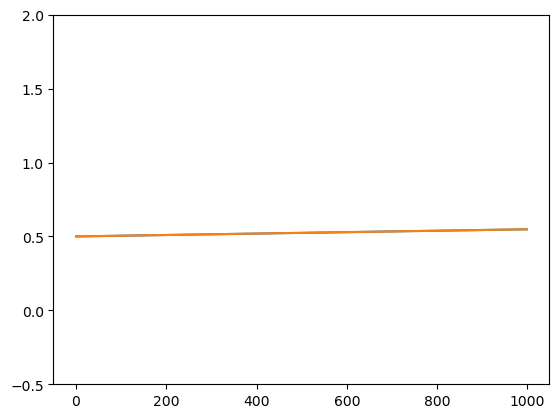

In [46]:
plt.plot(x_test[0])
plt.plot(input_signal(np.linspace(0,1000,1000), x_der_test[0]))
plt.ylim((-0.5,2))

In [25]:
import warnings
import numpy as np
from scipy.integrate import odeint 
def simulate_reservoir_w_out_dynamics(weights, input_weights, input_der, sample_len,
                                 output_weights, init_state=None):
    """Simulate the dynamics of a reservoir.

    Given the internal weights that define the reservoir, the input weights,
    the input signal stream, the initial state and the integrative function
    that the nodes apply, it computes the dynamics of the reservoir.

    Parameters
    ----------
    weights : numpy array
        Weighted adjacency matrix that defines the connectivity of the
        reservoir. Must be squared.
    input_weights : numpy array
        Weights that determine the effect of the input signal stream on each of
        the nodes of the reservoir. Rows are input streams (there might be more
        than one) and columns correspond to reservoir nodes (equal to number of
        rows and columns of `weights`).
    init_state : None, numpy array, optional (default=None)
        Value of the nodes of the reservoir at the initial time step. It must
        be a 1-dimensional vector of the length of the reservoir size. If
        `None` all nodes are initialized at `0`.
    node_function : None, Function, optional (default=None)
        Function applied to the weigted sum of all the incomming connections of
        a node to compute its state. It defaults to the hiperbolic tangent.
    """
    nnodes = weights.shape[0]
    n_outs = output_weights.shape[0] # Wout = nout * nnodes
    tot = nnodes + n_outs
    k=0.05 # protein production
    d=0.05 # protein degradation
    
    def sigmoid(x):
        return 0.5*((x-0.5)/np.sqrt((x-0.5)**2+0.1)+1)
    
    def input_signal(t, input_der):
        if (input_der > 0.0008) and (input_der < 0.001):
            return input_der*t 
        elif (input_der > -0.0001) and (input_der < 0.0001):
            return input_der*t + 0.5
        else:
            return input_der*t + 1.0
        
    def dyn(x, t, input_der):
        dxdt = np.zeros(tot)
        x_res = x[:nnodes]
        x_out = x[nnodes:]
        r = np.dot(weights, x_res)
        r_out = np.dot(output_weights, x_res)
        for i in range(nnodes):
            dxdt[i] = k * sigmoid(input_weights[i]*input_signal(t, input_der) + r[i]) - d * x_res[i] # dinamica de los genes del reservorio, ecuacion 1 del TFM
        for i in range(n_outs): # dinamica de los genes del output
            dxdt[i+nnodes] = k * sigmoid(r_out[i]) - d * x_out[i] 
        return dxdt


    x0 = np.repeat(0,tot)
    if init_state is not None:
        x0 = init_state 
    
    t = np.linspace(0,sample_len,sample_len)

    x = odeint(dyn, x0, t, args=(input_der,))
    
    #np.savetxt('output.csv', x)
    return x.T

In [47]:
input_der = x_der_test[0]
y_target =  y_test[0].T # nout * lensteps
res_dynamics = simulate_reservoir_w_out_dynamics(W, Win, input_der, sample_len, Wout)
# res_dynamics.shape = nodes * sample_len
#res_dynamics = np.vstack([np.ones(sample_len), res_dynamics])
#y_pred = np.dot(Wout, res_dynamics)

In [48]:
y_pred = res_dynamics[70:]

(-0.05, 1.05)

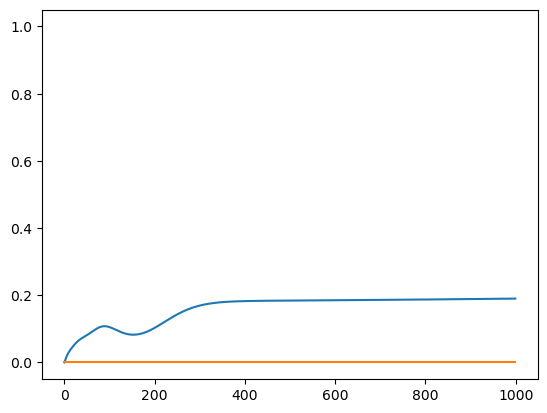

In [49]:
plt.plot(y_pred[0])
plt.plot(y_target[0])
plt.ylim((-0.05, 1.05))

(-0.05, 1.05)

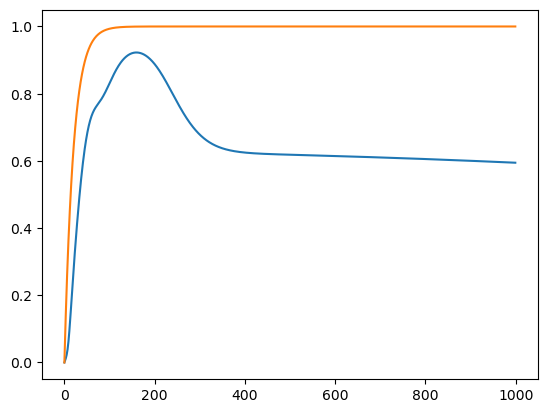

In [50]:
plt.plot(y_pred[1])
plt.plot(y_target[1])
plt.ylim((-0.05, 1.05))

(-0.05, 1.05)

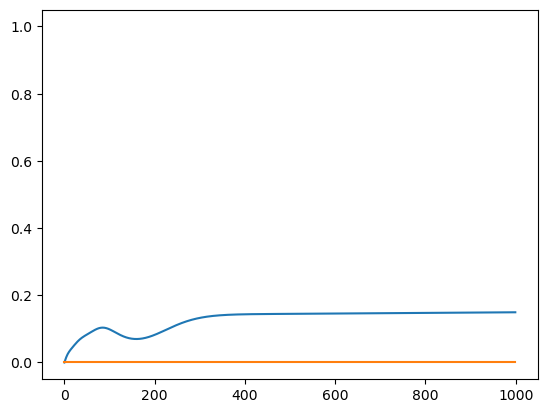

In [51]:
plt.plot(y_pred[2])
plt.plot(y_target[2])
plt.ylim((-0.05, 1.05))

# Training 4th gene

In [33]:
sample_len=1000
n_samples=100
[x, y, x_der] = datasets.gaosc(n_samples=n_samples, sample_len=sample_len)

In [34]:
xxT = 0
yxT = 0
for i in range(len(x)):
    input_der = x_der[i]
    y_target =  y[i].T # nout * lensteps
    res_dynamics = simulate_reservoir_dynamics(W, Win, input_der, sample_len)
    # res_dynamics.shape = nodes * sample_len
    #res_dynamics = np.vstack([np.ones(sample_len)/n_samples, res_dynamics])
    xxT += (np.dot(res_dynamics, res_dynamics.T))
    yxT += (np.dot(y_target, res_dynamics.T))

In [35]:
reg = 1e-8 
#Wout = np.dot( yxT, linalg.inv( xxT  + reg*np.eye(1+resSize) ) )
Wout = np.dot( yxT, linalg.inv( xxT  + reg*np.eye(resSize) ) )

In [36]:
Wout.shape

(1, 70)

In [72]:
sample_len=1000
[x_test, y_test, x_der_test] = datasets.gaosc(n_samples=1, sample_len=sample_len)

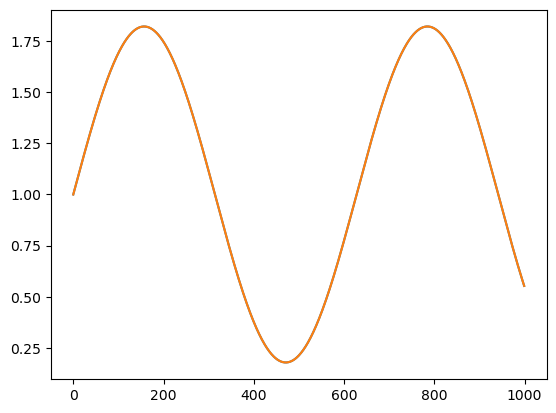

In [73]:
plt.plot(x_test[0])
plt.plot(input_signal(np.linspace(0,1000,1000), x_der_test[0]))

In [74]:
input_der = x_der_test[0]
y_target =  y_test[0].T # nout * lensteps
res_dynamics = simulate_reservoir_w_out_dynamics(W, Win, input_der, sample_len, Wout)
# res_dynamics.shape = nodes * sample_len
#res_dynamics = np.vstack([np.ones(sample_len), res_dynamics])
#y_pred = np.dot(Wout, res_dynamics)

In [75]:
res_dynamics.shape

(71, 1000)

In [76]:
y_pred = res_dynamics[70:]

(-0.05, 1.05)

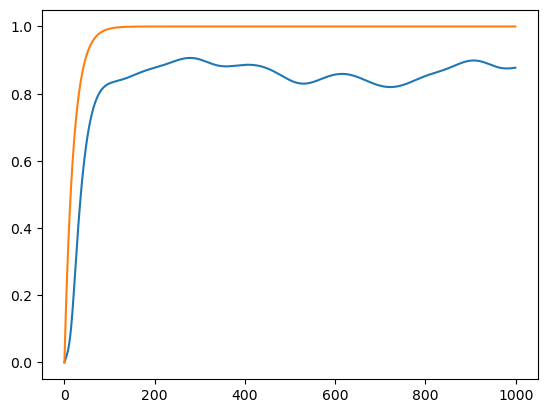

In [77]:
plt.plot(y_pred[0])
plt.plot(y_target[0])
plt.ylim((-0.05, 1.05))